# Main

##Data

In [1]:
!gdown --id 1rR0CjYZDgMfZDVYlyPxJdYpDN1XH5AYq

Downloading...
From: https://drive.google.com/uc?id=1rR0CjYZDgMfZDVYlyPxJdYpDN1XH5AYq
To: /content/mini_fer2013.csv
144MB [00:00, 217MB/s]


##Main Imports


In [2]:
import pandas as pd
!pip install opencv-python
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import gdown
import dlib
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
!pip install face_recognition
import face_recognition as fr
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix

     |████████████████████████████████| 100.2MB 53kB/s 
  Created wheel for face-recognition-models: filename=face_recognition_models-0.3.0-py2.py3-none-any.whl size=100566184 sha256=3fab515a95449cc8cb92770afd0ca4baa7b7671586960220e286a242248f8914
  Stored in directory: /root/.cache/pip/wheels/d2/99/18/59c6c8f01e39810415c0e63f5bede7d83dfb0ffc039865465f
Successfully built face-recognition-models


##Definitions

In [3]:
df = pd.read_csv('mini_fer2013.csv')
df_test = df.loc[df['Usage'] == 'Test']
XY_test = df_test.sample(frac=1).reset_index(drop=True)
df_tov = df.loc[df['Usage'] == 'ToV']
XY_tov = df_tov.sample(frac=1).reset_index(drop=True)
emotions = ['enojo','asco','miedo','alegria','tristeza','sorpresa','neutral']
face_parts = ['chin','left_eyebrow','right_eyebrow','nose_bridge','nose_tip',
              'left_eye','right_eye','top_lip','bottom_lip']

##Functions

In [4]:
def to_photo(row):
  int_pixels = []
  row_pixels = row.split()

  for pixel in row_pixels:
    int_pixels.append(int(pixel))

  uint_image = np.array(int_pixels)
  uint_image = uint_image.reshape(48,48)
  uint_image = uint_image.astype(np.uint8)
  gray = cv2.cvtColor(uint_image , cv2.COLOR_RGB2BGR)
  return gray

In [5]:
def check_emotions(row, emotions, p_emotions):
  current_emotion = emotions[row]
  if current_emotion in p_emotions:
    return False, p_emotions, current_emotion
  else:
    p_emotions.append(emotions[row])
    return True, p_emotions, current_emotion

In [6]:
def face_dots(face_parts, image):
  x_landmark = []
  y_landmark = []
  y_landmark_r = []
  face_landmarks_list = fr.face_landmarks(image)
  for part in face_parts:
    if len(face_landmarks_list) > 0:
      if part in face_landmarks_list[0]:
        for i in range(0,len(face_landmarks_list[0][part]) - 1):
          x_landmark.append(face_landmarks_list[0][part][i][0])
          y_landmark.append(face_landmarks_list[0][part][i][1])
          y_landmark_r.append(-face_landmarks_list[0][part][i][1])
  return x_landmark, y_landmark, y_landmark_r

In [7]:
def to_set(row):
  int_pixels = []
  row_pixels = row.split()

  for pixel in row_pixels:
    int_pixels.append(int(pixel))

  image = np.array(int_pixels)
  #image = image.astype(np.uint8)
  return image

In [8]:
def to_X(XY_tov, XY_test):
  X_train = []
  Y_train = []
  X_val = []
  Y_val = []
  X_test = []
  Y_test = []
  X_train_df = XY_tov['pixels'][:int(len(XY_tov)* 0.8)]
  Y_train_df = XY_tov['emotion'][:int(len(XY_tov)* 0.8)]
  X_val_df = XY_tov['pixels'][int(len(XY_tov)* 0.8):]
  Y_val_df = XY_tov['emotion'][int(len(XY_tov)* 0.8):]
  X_test_df = XY_test['pixels']
  Y_test_df = XY_test['emotion']

  for x_train_row in X_train_df:
    train_image = to_photo(x_train_row)
    if len(fr.face_encodings(train_image)) != 0:
      etrain_image = fr.face_encodings(train_image)[0]
      X_train.append(etrain_image)
    else:
      X_train.append(np.zeros(shape=128))

  for x_val_row in X_val_df:
    val_image = to_photo(x_val_row)
    if len(fr.face_encodings(val_image)) != 0:
      eval_image = fr.face_encodings(val_image)[0]
      X_val.append(eval_image)
    else:
      X_val.append(np.zeros(shape=128))

  for x_test_row in X_test_df:
    test_image = to_photo(x_test_row)
    if len(fr.face_encodings(test_image)) != 0:
      etest_image = fr.face_encodings(test_image)[0]
      X_test.append(etest_image)
    else:
      X_test.append(np.zeros(shape=128))

  for y_train_row in Y_train_df:
    Y_train.append(y_train_row)

  for y_val_row in Y_val_df:
    Y_val.append(y_val_row)
  
  for y_test_row in Y_test_df:
    Y_test.append(y_test_row)

  return X_train, Y_train, X_val, Y_val, X_test, Y_test, Y_train_df, Y_val_df

# P1

## P1.1

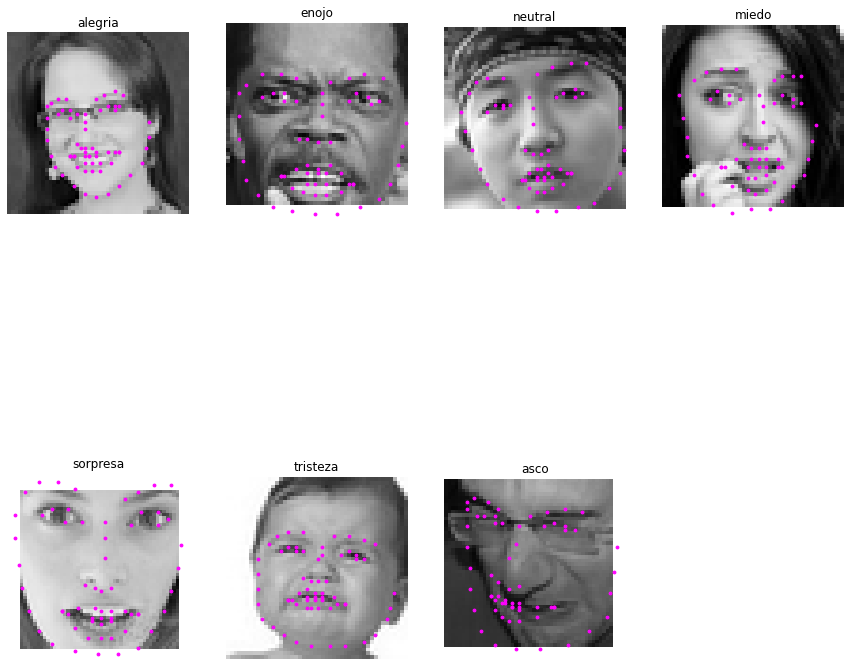

In [9]:
array = plt.figure(figsize=(15, 15))
array_rows = 2
array_columns = 4
all_emotions = False
while not all_emotions:
  p_emotions = []
  images_emotions = df_tov['emotion']
  images_pixels = df_tov['pixels']
  for i in range(2,len(images_emotions)):
    printeable, p_emotions, current_emotion = check_emotions(images_emotions[i]
                                                             , emotions, 
                                                             p_emotions)
    if printeable:
      image = to_photo(images_pixels[i])
      x_landmark, y_landmark, y_landmark_r = face_dots(face_parts, image)
      array.add_subplot(array_rows, array_columns, len(p_emotions))
      plt.imshow(image, cmap = 'gray')
      plt.axis('off')
      plt.scatter(x_landmark, y_landmark, color = 'magenta', s = 8,)
      plt.title(current_emotion)
    if len(p_emotions) == 7:
      all_emotions = True

##P1.2

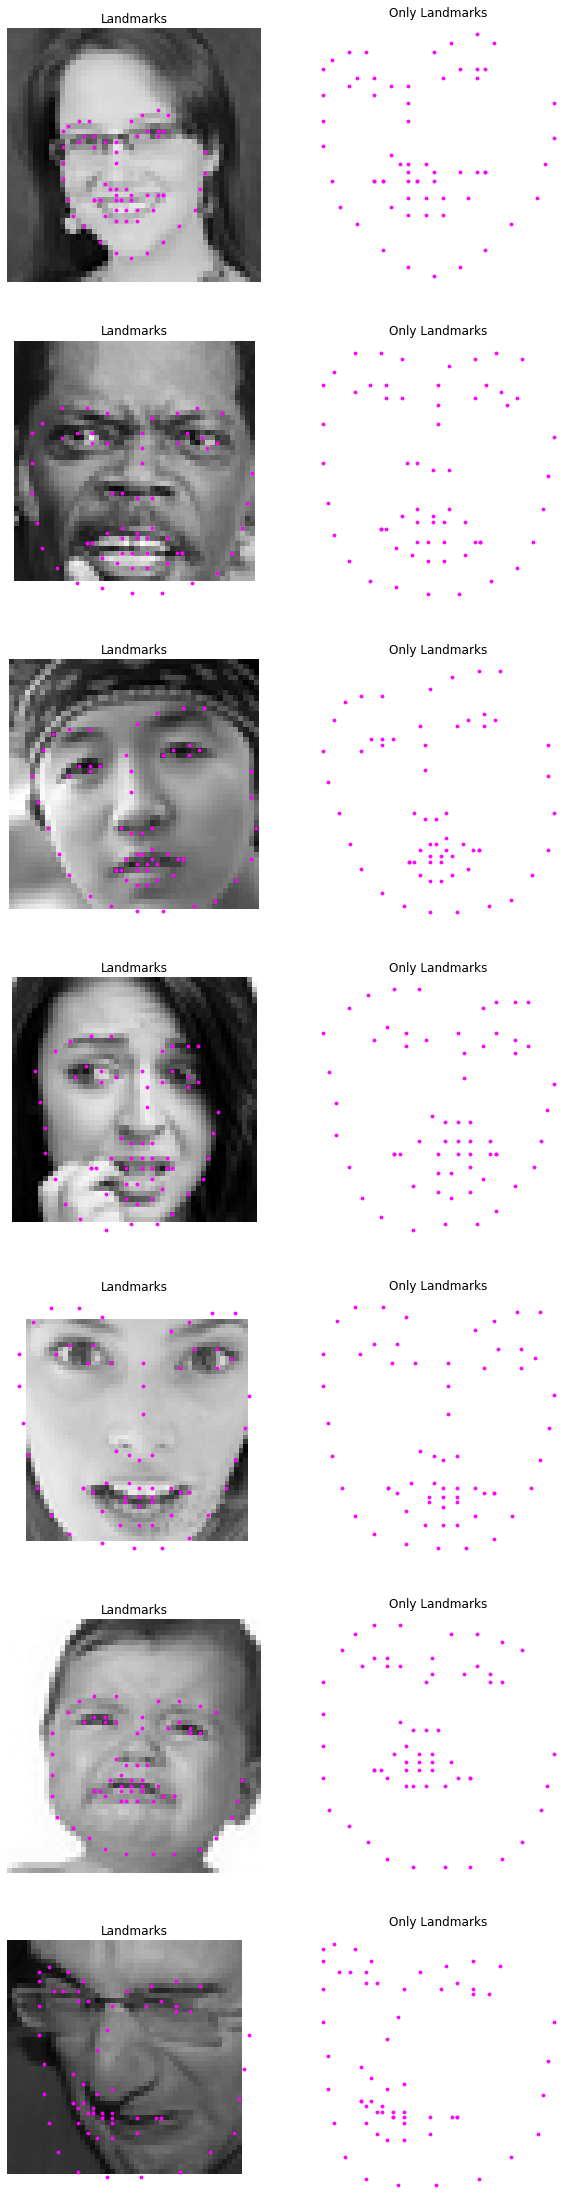

In [10]:
fig, axs = plt.subplots(7, 2,figsize=(10, 40))
all_emotions = False
while not all_emotions:
  p_emotions = []
  images_emotions = df_tov['emotion']
  images_pixels = df_tov['pixels']
  for i in range(2,len(images_emotions)):
    printeable, p_emotions, current_emotion = check_emotions(images_emotions[i]
                                                             , emotions, 
                                                             p_emotions)
    if printeable:
      image = to_photo(images_pixels[i])
      x_landmark, y_landmark, y_landmark_r = face_dots(face_parts, image)
      axs[len(p_emotions) - 1, 0].imshow(image, cmap = 'gray')
      axs[len(p_emotions) - 1, 
          0].scatter(x_landmark, y_landmark, color = 'magenta', s = 8)
      axs[len(p_emotions) - 1, 0].axis('off')
      axs[len(p_emotions) - 1, 0].set_title('Landmarks')  
      axs[len(p_emotions) - 1, 
          1].scatter(x_landmark, y_landmark_r, color = 'magenta', s = 8)
      axs[len(p_emotions) - 1, 1].axis('off')
      axs[len(p_emotions) - 1, 1].set_title('Only Landmarks')  

    if len(p_emotions) == 7:
      all_emotions = True

# P2

###Xs definitions

In [11]:
X_train, Y_train, X_val, Y_val, X_test, Y_test, Y_train_df, Y_val_df = to_X(XY_tov, XY_test)
print(len(X_train))
print(len(X_val))
print(len(X_test))

12364
3091
1705


In [12]:
print(len(X_train[0]))

128


Se separo el subconjunto "ToV" en 80% training set y 20% validation set, con el fin de que se ocupen la mayor cantidad de datos aleatorios en entrenar nuestro algoritmo. Por que no usarlo 100% entonces? Porque debemos reservar una parte del set para ajustar hiperparametros, por ello, dejamos un 20% del set "ToV" para validacion.
El set de entrenamiento tiene 12,364 ejemplos, mientras que el set de validacion tiene 3,091 ejemplos.
El maximo de caracteristicas que puede tener la matriz X es 2,304 (48x48) por cada ejemplo que contenga, sin embargo, a traves del modulo "face_recognition.face_encodings" logramos disminuir esos elementos a 128, lo que facilita el entrenamiento de los algoritmos. Por ejemplo, la matriz X del set de entrenamiento contiene 12,364 instancias, de esta manera, como cada instancia puede tener hasta 128 caracteristicas, el total de caracteristicas, considerando todos los ejemplos es de 12,364 x 128 = 1,582,592.

In [13]:
print('Set de entrenamiento')
for i in range(1, len(emotions)):
  print(f'{i} - {emotions[i]}: {len(Y_train_df.loc[Y_train_df == i])}')

Set de entrenamiento
1 - asco: 87
2 - miedo: 837
3 - alegria: 4589
4 - tristeza: 1051
5 - sorpresa: 1494
6 - neutral: 2850


In [14]:
print('Set de validacion')
for i in range(1, len(emotions)):
  print(f'{i} - {emotions[i]}: {len(Y_val_df.loc[Y_val_df == i])}')

Set de validacion
1 - asco: 19
2 - miedo: 196
3 - alegria: 1109
4 - tristeza: 284
5 - sorpresa: 394
6 - neutral: 723


# P3

## P3.1 SVM

###Value definitions

In [15]:
Cs = [1, 5, 10, 20,50]
SVMs = ['linear', 'rbf', 'sigmoid']

###Tests

In [16]:
for i in SVMs:
  print(f'Probando modelo: {i}')
  for j in Cs:
    l_clf = SVC(kernel=i, C = j)
    l_clf.fit(X_train, Y_train)
    l_prediction = l_clf.predict(X_val)
    acc = accuracy_score(Y_val, l_prediction)
    print(f'- Para valor de C: {j} el accuracy del metodo es {acc*100}%')

Probando modelo: linear
- Para valor de C: 1 el accuracy del metodo es 54.06017470074409%
- Para valor de C: 5 el accuracy del metodo es 55.38660627628599%
- Para valor de C: 10 el accuracy del metodo es 55.6454221934649%
- Para valor de C: 20 el accuracy del metodo es 56.2601099967648%
- Para valor de C: 50 el accuracy del metodo es 56.38951795535425%
Probando modelo: rbf
- Para valor de C: 1 el accuracy del metodo es 56.745389841475244%
- Para valor de C: 5 el accuracy del metodo es 60.78938854739566%
- Para valor de C: 10 el accuracy del metodo es 62.859915884826925%
- Para valor de C: 20 el accuracy del metodo es 63.95988353283727%
- Para valor de C: 50 el accuracy del metodo es 63.47460368812682%
Probando modelo: sigmoid
- Para valor de C: 1 el accuracy del metodo es 41.08702685215141%
- Para valor de C: 5 el accuracy del metodo es 39.566483338725334%
- Para valor de C: 10 el accuracy del metodo es 34.84309285021029%
- Para valor de C: 20 el accuracy del metodo es 38.4341637010676

##P3.2 Decision Tree

###Value definitions

In [17]:
MDs = [1, 10, 20, 50,100,200,500]
CRNs = ['gini', 'entropy']

###Tests

In [18]:
for i in CRNs:
  print(f'Probando modelo: {i}')
  for j in MDs:
    dtc = DecisionTreeClassifier(criterion=i, max_depth = j)
    dtc.fit(X_train, Y_train)
    dtc_prediction = dtc.predict(X_val)
    acc = accuracy_score(Y_val, dtc_prediction)
    print(f'- Para valor de C: {j} el accuracy del metodo es {acc*100}%')

Probando modelo: gini
- Para valor de C: 1 el accuracy del metodo es 37.72241992882562%
- Para valor de C: 10 el accuracy del metodo es 41.37819475897768%
- Para valor de C: 20 el accuracy del metodo es 42.219346489809126%
- Para valor de C: 50 el accuracy del metodo es 41.83112261404076%
- Para valor de C: 100 el accuracy del metodo es 41.7987706243934%
- Para valor de C: 200 el accuracy del metodo es 42.057586541572306%
- Para valor de C: 500 el accuracy del metodo es 42.057586541572306%
Probando modelo: entropy
- Para valor de C: 1 el accuracy del metodo es 36.75186023940472%
- Para valor de C: 10 el accuracy del metodo es 40.34293109026205%
- Para valor de C: 20 el accuracy del metodo es 40.86056292461986%
- Para valor de C: 50 el accuracy del metodo es 41.50760271756713%
- Para valor de C: 100 el accuracy del metodo es 40.98997088320932%
- Para valor de C: 200 el accuracy del metodo es 40.95761889356196%
- Para valor de C: 500 el accuracy del metodo es 41.50760271756713%


##P3.3 Gaussian NB

El accuracy del metodo es: 39.30766742154643%


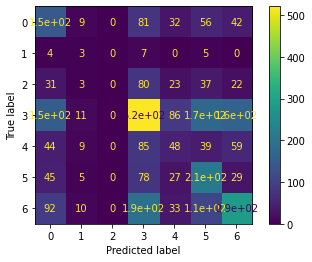

In [19]:
nb_clf = GaussianNB()
nb_clf.fit(X_train, Y_train)
nb_prediction = nb_clf.predict(X_val)
acc = accuracy_score(Y_val, nb_prediction)
cm = confusion_matrix(Y_val, nb_prediction)
print(f'El accuracy del metodo es: {acc*100}%')
plot_confusion_matrix(nb_clf, X_val, Y_val)  
plt.show()  

El metodo con mayor efectividad es SVM con kernel RBF y en particular, con C = 50, logrando un accuracy cercano al 64%. La menor efectividad entre todos los metodos tambien se presenta en SVM y fue el con kernel Sigmoid y en particular con C = 50, con una efectividad cercana al 38%. 

Cerca de la menor efectividad presentada a nivel general, se encuentra el calsificador DecisionTreeClassifier, con ambas variables de "criterion", gini y entropy, en particular con C = 1, logrando una efectividad cercana al 39%.

Además, notamos que el método DecisionTreeClassifier y Bayes Ingenuo tiene un tiempo de ejecución considerablemente menor a SVM.



# P4 - Analisis de datos

Mejor resultado

In [20]:
XY_test = df_test.sample(frac=1).reset_index(drop=True)

El accuracy del metodo es: 63.47460368812682%


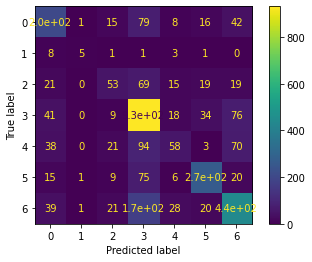

In [21]:
r_clf = SVC(kernel='rbf', C = 50)
r_clf.fit(X_train, Y_train)
r_prediction = r_clf.predict(X_val)
acc = accuracy_score(Y_val, r_prediction)
cm = confusion_matrix(Y_val, r_prediction)
print(f'El accuracy del metodo es: {acc*100}%')
plot_confusion_matrix(r_clf, X_val, Y_val)  
plt.show()  

In [22]:
zeros = 200 + 1 + 12 + 74 + 21 + 10 + 41
ones = 4 + 8 + 2 + 1 + 3
twos = 28 + 49 + 45 + 17 + 12 + 29
threes = 51 + 1 + 14 + 1300 + 18 + 35 + 82
fours = 26 + 15 + 100 + 73 + 7 + 63
fives = 11 + 9 + 64 + 7 + 290 + 22
sixs = 40 + 15 + 170 + 32 + 17 + 440
numbers = [zeros, ones, twos, threes, fours, fives, sixs]
for i in numbers:
  print(i)

359
18
180
1501
284
403
714


Valores aproximados a partir de la matriz de confusion

Clasificaciones totales ->
0: 359;
1: 18;
2: 180;
3: 1501;
4: 284;
5: 403;
6: 714

Clasificaciones acertadas ->
0: 200;
1: 0;
2: 49;
3: 1300;
4: 73;
5: 290;
6: 440

Clasificaciones erradas ->
0: 159;
1: 18;
2: 131;
3: 201;
4: 211;
5: 113;
6: 274

Eficacia ->
0: .557;
1: .000;
2: .272;
3: .866;
4: .257;
5: .720;
6: .616

A partir de la matriz de confusion podemos rescatar que este metodo es altamente eficaz al momento de detectar el la emocion "alegria" (3), ya que fue la emocion bien calificada en una mayor cantidad de ocasiones, ademas de ser la emocion que porcentualmente fue acertivamente clasificada de buena manera, con cerca de un 87% de efectividad.

Podemos mencionar que la emocion "neutral" (6) fue la que mas **veces** fue clasificada de manera erronea, con 164 ocurrencias. En particular el metodo se "confunde" principalmente con la emocion "alegria" (3), cuya etiqueta fue asignada cerca de 170 veces. Sin embargo, hablando de porcentaje de efectividad, es la tercera emocion con mejor rendimiento, con cerca de un 62% de casos bien clasificados.

Finalmente, la emocion que tuvo un menor **porcentaje** de aciertos, es decir, la que tuvo mayores dificultades para ser clasificada de manera correcta, fue la emocion "asco" (1), con tan solo un 0.00% de efectividad de clasificacion. Seguida por la emocion "tristeza" (4). 

Con respecto a la emocion asco, podemos mencionar que le toco clasificar muy pocos ejemplos, lo que nos permite pensar que al algoritmo le faltaron ejemplos para poder detectar patrones en las expresiones faciales de esa emocion.

##Imagenes

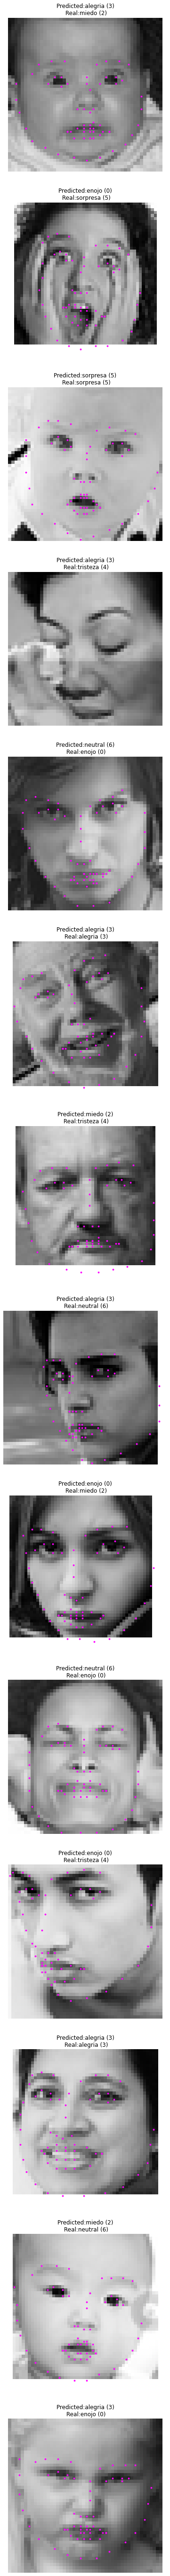

In [23]:
fig, axs = plt.subplots(14, 1,figsize=(10, 100))
all_emotions = False
while not all_emotions:
  p_emotions = []
  images_emotions = XY_test['emotion']
  images_pixels = XY_test['pixels']
  for i in range(1,15):
    printeable, p_emotions, current_emotion = check_emotions(images_emotions[i]
                                                             , emotions, 
                                                             p_emotions)

    image = to_photo(images_pixels[i])
    x_landmark, y_landmark, y_landmark_r = face_dots(face_parts, image)
    axs[i - 1].imshow(image, cmap = 'gray')
    axs[i - 1].scatter(x_landmark, y_landmark, color = 'magenta', s = 8)
    axs[i - 1].axis('off')
    axs[i - 1].set_title(f'Predicted:{emotions[r_prediction[i]]} ({r_prediction[i]})\n Real:{current_emotion} ({emotions.index(current_emotion)})')  
    if i == 14:
      all_emotions = True

Al observar las imagenes, nos damos cuenta de que la forma en que esta dispuesta la **boca** en las imagenes con emocion "neutral" (6) es muy similar a la forma que se muestra en las imagenes con emocion "alegria" (3), cuyo gesto en varias ocasiones es una leve sonrisa. Este puede ser uno de los factores principales de la "confusion" al momento de clasificar.

También ponemos especial atención en las caras que demuestran una emoción de "tristeza" (4) y nos encontramos con rosotros con pocas marcas faciales distintivas y bastante diversas. Por ejemplo, dentro del set de test encontramos caras de guaguas llorando (boca abierta y rostro expresivo) que están etiquetadas originalmente como emoción de "tristeza" (4) como también fotos de personas adultas con la mirada baja y un rostro que fácilmente puede ser confundido por un humano como "neutral" (6). De esta manera, al no existir cierto patrón claro de marcas faciales que el método pueda distinguir, es natural entender por qué a este le cuesta clasificar nuevos ejemplos. Una solución posible es entrenar al método con más ejemplos de "tristeza" (4), con el fin de que este pueda detectar más fácilmente patrones de marcas faciales que le permitan clasificar de manera correcta futuras muestras.



# P5 - Test Set

El accuracy del metodo es: 63.929618768328446%


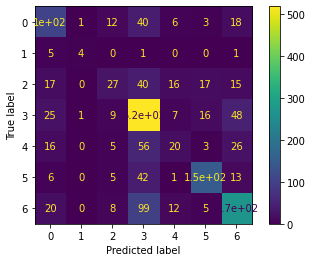

[[104   1  12  40   6   3  18]
 [  5   4   0   1   0   0   1]
 [ 17   0  27  40  16  17  15]
 [ 25   1   9 518   7  16  48]
 [ 16   0   5  56  20   3  26]
 [  6   0   5  42   1 148  13]
 [ 20   0   8  99  12   5 269]]


In [24]:
r_clf = SVC(kernel='rbf', C = 50)
r_clf.fit(X_train, Y_train)
r_prediction = r_clf.predict(X_test)
acc = accuracy_score(Y_test, r_prediction)
cm = confusion_matrix(Y_test, r_prediction)
print(f'El accuracy del metodo es: {acc*100}%')
plot_confusion_matrix(r_clf, X_test, Y_test)  
plt.show()
print(cm)

El algoritmo que mejor funciono en el set de validacion fue el SVM con kernel 'RBF' y C = 50. En el set mencionado tuvo un accuracy cercano al 64.15%, mientras que en el set de test cerca de un 63.29%, es decir, cerca de un 1% menos.

Esta pequena variacion es esperable, ya que los ejemplos de cada set son distintos y pueden presentar mas o menos ejemplos de emociones que el algoritmo clasifique con mayor o menor facilidad. 

Si bien el accuracy del algoritmo nos indica que nos falta entrenarlo (a penas tiene sobre un 60% de efectividad), al ser una diferencia pequena entre set de validacion y set de test, podemos decir que no presenta underfitting u overfitting.

Siguiendo la linea del parrafo anterior, tambien podemos notar que la matriz de confusion del algoritmo es bastante similar en ambos sets, si bien varia la cantidad de aciertos/errores debido a la composicion de cada uno de los sets, podemos notar que el mapa de calor en ambos casos se parece bastante y podemos notar facilmente que la emocion "alegria" (3) es la que tiene mejor ratio de clasificacion nuevamente, asi como la "tristeza" (4) se ubica otra vez dentro de las emociones mas dificiles de clasificar para el algoritmo.

# P6 - *Bagging y Boosting*

## Algoritmos Ensamblados

Primero debemos partir por entender que los **algoritmos ensamblados** son corresponden a una composicion de algoritmos simples que dan origen a un algoritmo mas robusto. Existen diversas formas de realizar esta union o "ensamblaje" de algoritmos, entre las mas populares se encuentran las mencionadas en el enunciado, el *bagging* y el *boosting*.

## *Bagging*

Los algoritmos de bagging son aquellos que se corren en paralelo y el algoritmo que surge a partir del ensamblaje de estos algoritmos simples se aprovecha de la independencia que tienen estos al funcionar en paralelo, disminuyendo la varianza del output final al promediar los suboutputs de los algoritmos componentes.

## *Boosting*

Los algoritmos de boosting son aquellos que se corren secuencialmente, es decir, los algoritmos simples forman una especie de cadena de ejecucion, en la que se busca que los algoritmos recopilen los errores de sus antecesores y los intenten aprender de cierta manera, minimizando asi el sesgo del output final.

## Comparacion

Podemos ver que la principal diferencia entre ambas tecnicas de ensamblaje de algoritmos reside en la temporalidad que estos asignan a sus componentes. Mientras que el bagging se aprovecha de la independecia de los resultados, el boosting se aprovecha del "doble check" que pueda hacer un algoritmo sobre los errores identificados en el algoritmo anterior.

Por un lado, el bagging lo podemos ver como una mesa democratica en que el output elegido sera el "mas votado" por los integrantes de la mesa (los algoritmos simples). Este metodo sera especialmente util cuando nuestros algoritmos presenten alta varianza.

Por el otro, el boosting lo podemos ver como una cadena de evaluacion, en que distintos especialistas (los algoritmos simples) van revisando el producto (input pre-procesado) ya revisado por su companero anterior, de esta manera, van "parchando" secuencialmente los errores cometidos por el "especialista" anterior.


Referencias:

[MachineLearning para todos](https://machinelearningparatodos.com/cual-es-la-diferencia-entre-los-metodos-de-bagging-y-los-de-boosting/)

[Ciencia de datos](https://www.cienciadedatos.net/documentos/33_arboles_decision_random_forest_gradient_boosting_c50)

## Mi eleccion para este set

Sin duda mi eleccion para este set de datos seria la implementacion de boosting, ya que como mencione en preguntas anteriores, el mejor de los metodos de clasificacion llega a penas al 64% de accuracy.

Al generar un algortimo mas robusto a partir del boosting, se podria implementar una cadena de algoritmos que prestaran mas atencion a las caracteristicas de, por ejemplo, las emociones "asco" (1) y "tristeza" (4) que tan bajo acierto tienen al momento de ser clasificadas, de esta manera aumentaria de manera significativa el accuracy general del metodo.